In [38]:
import requests
import osmnx as ox
import networkx as nx
import geopandas as gpd
import numpy as np
import pandas as pd

                                            geometry  bbox_north  bbox_south  \
0  POLYGON ((301997.266 -4082816.606, 302016.825 ...  -36.867678  -36.870725   

    bbox_east   bbox_west   place_id osm_type    osm_id        lat  \
0  174.779537  174.778569  118523389      way  48383821 -36.869262   

          lon                                       display_name    class  \
0  174.778972  Newmarket, Joseph Banks Terrace, Newmarket, Au...  railway   

      type  importance  
0  station    0.460255  


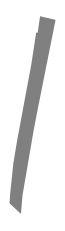

In [39]:
# Find Auckland location from osmx package
city = ox.geocode_to_gdf("NewMarket, Auckland, NZ")
city_proj = ox.project_gdf(city)
ax = city_proj.plot(fc="gray", ec="none")
_ = ax.axis("off")
print(city_proj)

In [81]:
gdf = ox.geometries.geometries_from_point((-36.8679152, 174.7774390),tags={'amenity':True,'shop':True},dist=100)
gdf.drop(['addr:housenumber', 'addr:street',
          'phone','website',
          'wheelchair','addr:city',
          'payment:coins','brand',
          'brand:wikidata',
          'brand:wikipedia',
          'cuisine',
          'operator','operator:wikidata','operator:wikipedia',
          'addr:postcode','opening_hours','opening_hours','addr:suburb','email','internet_access',
          'ref:linz:address_id','second_hand','access','fee','bicycle_parking','capacity','covered','nodes',
          'height','supervised','building:levels','layer','operator:type','payment:app','payment:credit_cards'
         ], axis=1, inplace=True)

poi_node_df_columns = ['amenity', 'name', 'geometry',  'shop', 'takeaway',
       'healthcare', 'parking', 'clothes', 'building']
poi_node_df = pd.DataFrame(columns=poi_node_df_columns)

for df_index in gdf.index.values:
    index_type = df_index[0]
    osm_node_id = df_index[1]
    if index_type=="way":
        continue
    row = gdf.loc[df_index]
    poi_node_df = pd.concat([poi_node_df,pd.DataFrame([row],
                                            columns=poi_node_df_columns,
                                            index=[osm_node_id])])
print(poi_node_df.head())

             amenity              name                         geometry shop  \
65389942      cinema  Rialto Newmarket  POINT (174.7775985 -36.8683617)  NaN   
331410256    toilets               NaN   POINT (174.7782315 -36.867124)  NaN   
666779075  telephone               NaN  POINT (174.7777625 -36.8676572)  NaN   
666779076  telephone               NaN  POINT (174.7778657 -36.8683972)  NaN   
666779078   post_box               NaN  POINT (174.7782314 -36.8678756)  NaN   

          takeaway healthcare parking clothes building  
65389942       NaN        NaN     NaN     NaN      NaN  
331410256      NaN        NaN     NaN     NaN      NaN  
666779075      NaN        NaN     NaN     NaN      NaN  
666779076      NaN        NaN     NaN     NaN      NaN  
666779078      NaN        NaN     NaN     NaN      NaN  


In [76]:
highway_G = ox.graph_from_point(
    (-36.8679152, 174.7774390),
    dist=100,
    dist_type="network",
    network_type="walk",
    simplify=False,
    retain_all=True,
    custom_filter = '["highway"~"unclassified|trunk|primary|tertiary|secondary|track|path|residential"]'
)

print(highway_G)

MultiDiGraph with 12 nodes and 22 edges


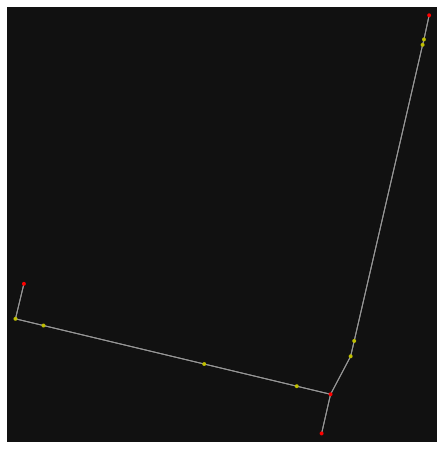

In [78]:
# turn off strict mode and see what nodes we'd remove, in yellow
nc = ["r" if ox.simplification._is_endpoint(highway_G, node) else "y" for node in highway_G.nodes()]
fig, ax = ox.plot_graph(highway_G, node_color=nc)

In [112]:
# 给POI node找到最近的路段，取出该POI node的Amenity类型 或者shop 类型
# 把node id，poi类型，边的node pair 存进一个DF
def find_edge_for_node(road_G,poi_df):
    columns = ["source","target","distance_to_edge",'amenity', 'name', 'geometry', 'shop', 'takeaway',
       'healthcare', 'parking', 'clothes', 'building']
    output_df = pd.DataFrame(columns=columns)
    road_nodes = road_G.nodes(data=True)

    for row in poi_df.iterrows():
        node_id, node_detail = row[0], row[1]
        coord = node_detail["geometry"]

        # 找出poi和 路段起始 或者 路段末端 的距离
        u,v,_= ox.distance.nearest_edges(road_G, coord.x,coord.y,return_dist=False)

        print("coord ",coord.y,coord.x)
        print("start ",road_nodes[u]["y"],road_nodes[u]["x"])
        print("end ",road_nodes[v]["y"],road_nodes[v]["x"])
        distance_to_road_start = ox.distance.euclidean_dist_vec(coord.y,coord.x,
                                                              road_nodes[u]["y"],road_nodes[u]["x"])
        distance_to_road_end = ox.distance.euclidean_dist_vec(coord.y,coord.x,
                                                            road_nodes[v]["y"],road_nodes[v]["x"])
        average_distance_to_poi = (distance_to_road_start+ distance_to_road_end)/2

        print(distance_to_road_start,distance_to_road_end,average_distance_to_poi)
        mapping_row = [u,v,average_distance_to_poi]
        mapping_row= mapping_row+list(node_detail.to_dict().values())
        output_df = pd.concat([output_df,pd.DataFrame([mapping_row],
                                            columns=columns,
                                            index=[node_id])])
    return output_df

In [113]:
poi_mapping_df = find_edge_for_node(highway_G,poi_node_df)
print(poi_mapping_df.head())

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8683617 174.7775985
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.00041477329953220016 0.000446756331797823 0.0004307648156650116
coord  -36.867124 174.7782315
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0008837925378661216 0.0009196707726294202 0.000901731655247771
coord  -36.8676572 174.7777625
start  -36.8675573 174.7774203
end  -36.8675074 174.7774352
0.00035648401086575167 0.00035995184398209424 0.00035821792742392295
coord  -36.8683972 174.7778657
start  -36.8682117 174.7772118
end  -36.86818 174.7772219
0.0006797024790316594 0.0006794514552234652 0.0006795769671275624
coord  -36.8678756 174.7782314
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0008708810768608158 0.001054395376517442 0.0009626382266891289


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8670632 174.777564
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0004624965729637913 0.0005145721523860964 0.0004885343626749438
coord  -36.8672764 174.7775997
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0002835864065747936 0.0003333004200457015 0.0003084434133102475
coord  -36.8671949 174.777581
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0003448389334098601 0.00039643189831686863 0.0003706354158633644
coord  -36.8673494 174.7784875
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0010640955267244671 0.0010872618130184763 0.0010756786698714717
coord  -36.8683069 174.7782213
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.001092284436416284 0.0010074244239760164 0.0010498544301961502
coord  -36.8681104 174.7782717
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0010124875505536555 0.0010521046525935845 0.00103229610157362


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8680176 174.7782925
start  -36.86818 174.7772219
end  -36.8675684 174.7774165
0.0010828472283668396 0.0009844575359088674 0.0010336523821378534
coord  -36.8684893 174.7781683
start  -36.8682117 174.7772118
end  -36.86818 174.7772219
0.0009959688800359268 0.0009956603085418388 0.0009958145942888827
coord  -36.8673135 174.7770649
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0004179943779650275 0.00043098445446721953 0.00042448941621612353
coord  -36.8678817 174.7766702
start  -36.8682207 174.7768329
end  -36.868133 174.7764198
0.0003760216616030667 0.0003547560429372182 0.00036538885227014245
coord  -36.8673204 174.7771075
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0003773013252171191 0.0003923843141554231 0.0003848428196862711
coord  -36.8671711 174.776475
start  -36.8681177 174.7763478
end  -36.8680454 174.7763717
0.0009551080567140603 0.0008803813832655295 0.0009177447199897948


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8675622 174.7772467
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.00016991315426834536 0.0006182975659025075 0.00039410536008542644
coord  -36.8675267 174.7770684
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0003505887904624491 0.000671091007246773 0.0005108398988546111
coord  -36.8672506 174.776754
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0007279970329641992 0.0007334988616023616 0.0007307479472832804
coord  -36.8675151 174.7770064
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.00041354915062881507 0.000698950828029676 0.0005562499893292456
coord  -36.8675766 174.7772974
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.00011938195003709831 0.0006081050978282011 0.0003637435239326497
coord  -36.8675263 174.7764197
start  -36.8681177 174.7763478
end  -36.8680454 174.7763717
0.0005957546223038223 0.0005213145020018434 0.0005585345621528328
coord  -36.867545 174.7771833
start  -36.86818 174.7772219
end  -

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8675355 174.7771263
start  -36.86818 174.7772219
end  -36.8675684 174.7774165
0.0006515516940363139 0.0002920589837637215 0.0004718053389000177
coord  -36.8674061 174.7763492
start  -36.8681177 174.7763478
end  -36.8680454 174.7763717
0.0007116013771793385 0.0006396958183418024 0.0006756485977605705
coord  -36.8683767 174.776982
start  -36.8682207 174.7768329
end  -36.8682712 174.7770707
0.0002157934429118485 0.00013783301490521413 0.00017681322890853132
coord  -36.8685784 174.776343
start  -36.868133 174.7764198
end  -36.8682207 174.7768329
0.0004519727867909647 0.0006065898943994697 0.0005292813405952172
coord  -36.8685053 174.7781194
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0009539070814332838 0.0009856904838742256 0.0009697987826537548
coord  -36.8684403 174.7781167
start  -36.86818 174.7772219
end  -36.8675684 174.7774165
0.0009318922308915239 0.001118252945453659 0.0010250725881725915
coord  -36.8671925 174.7775984
start  -36.8675074 174.7774352
en

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8680661 174.7765697
start  -36.8682207 174.7768329
end  -36.868133 174.7764198
0.0003052464577827343 0.00016415121077542939 0.00023469883427908183
coord  -36.8683369 174.7768942
start  -36.8682712 174.7770707
end  -36.8682207 174.7768329
0.00018833146312624818 0.00013137781395663767 0.00015985463854144294
coord  -36.8683324 174.7766709
start  -36.8682207 174.7768329
end  -36.868133 174.7764198
0.0001967762434745131 0.00032064243323776294 0.000258709338356138
coord  -36.8678632 174.7765343
start  -36.8681177 174.7763478
end  -36.8680454 174.7763717
0.0003155194130367098 0.0002442040130759676 0.0002798617130563387
coord  -36.8672213 174.7770999
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0004407712558844018 0.00046427595242284957 0.0004525236041536257
coord  -36.8672736 174.7776102
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.00029204013422184737 0.0003413908317544035 0.0003167154829881254


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8681403 174.7770945
start  -36.8682207 174.7768329
end  -36.8682712 174.7770707
0.00027367630516472377 0.00013304604466470087 0.00020336117491471232
coord  -36.8685544 174.7769842
start  -36.8682896 174.7771576
end  -36.8683705 174.7771321
0.0003165226690298296 0.00023599495757687002 0.00027625881330334983
coord  -36.8687934 174.7769025
start  -36.8682896 174.7771576
end  -36.8683705 174.7771321
0.0005647038604491815 0.000481207408500139 0.0005229556344746602
coord  -36.8684014 174.777666
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0004922232522001615 0.0005205475962892171 0.0005063854242446893
coord  -36.8684273 174.7777154
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.000547810478177066 0.0005745451505287907 0.0005611778143529284
coord  -36.8675138 174.776946
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0004736574817094582 0.0007210709049750934 0.0005973641933422758
coord  -36.8687799 174.7777416
start  -36.8683705 174.77713

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8684953 174.777171
start  -36.8682896 174.7771576
end  -36.8683705 174.7771321
0.00020613599879911975 0.00013072203334594542 0.00016842901607253257
coord  -36.8672627 174.7768098
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0006715677553489892 0.0006778638580084718 0.0006747158066787305
coord  -36.8677759 174.7783067
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0009119235165175808 0.0009129572388790553 0.000912440377698318
coord  -36.8672201 174.7776044
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0003334215499903393 0.00038418309438009273 0.000358802322185216
coord  -36.8673954 174.7772905
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.00018298111926223326 0.0002075081926085441 0.00019524465593538868
coord  -36.8673403 174.7772495
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0002498137306087886 0.0002761551013328786 0.0002629844159708336
coord  -36.8684544 174.7771898
start  -36.8682896 174.7

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8679053 174.7770817
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.00047496594613630406 0.00030840903035457795 0.000391687488245441
coord  -36.8670619 174.7781717
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0008607569343202101 0.0009000128443626095 0.0008803848893414099
coord  -36.8685783 174.7778056
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0006978495539784412 0.0007094023470377077 0.0007036259505080744
coord  -36.8685687 174.7771486
start  -36.8682896 174.7771576
end  -36.8683705 174.7771321
0.00027924507157730367 0.00019888562039631686 0.00023906534598681028
coord  -36.868707 174.7769296
start  -36.8682896 174.7771576
end  -36.8683705 174.7771321
0.00047561198472342517 0.0003927320969849536 0.0004341720408541894
coord  -36.8677602 174.776367
start  -36.8681177 174.7763478
end  -36.8680454 174.7763717
0.0003580152091737635 0.000285238724580471 0.0003216269668771172
coord  -36.868314 174.7778372
start  -36.8675684 174.77741

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8680704 174.7766211
start  -36.8682207 174.7768329
end  -36.868133 174.7764198
0.0002597100883589681 0.00021080903679502762 0.00023525956257699788
coord  -36.8679351 174.7767193
start  -36.8682207 174.7768329
end  -36.868133 174.7764198
0.00030736349815980795 0.0003589772416059945 0.00033317036988290125
coord  -36.8679386 174.777193
start  -36.86818 174.7772219
end  -36.8675684 174.7774165
0.00024312377506010888 0.0004324353015057879 0.0003377795382829484
coord  -36.8682933 174.7776679
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0007672561306398222 0.00046016615478389634 0.0006137111427118593
coord  -36.8683994 174.7776273
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0004559293146983925 0.00048236306865015243 0.00046914619167427247
coord  -36.8678216 174.7782994
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0009195451484242779 0.0009179712958661576 0.0009187582221452178


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8672271 174.7776145
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.00033274101038890464 0.0003830739876370913 0.000357907499012998
coord  -36.8680763 174.7766565
start  -36.8682207 174.7768329
end  -36.868133 174.7764198
0.00022796561143359844 0.00024339634342870648 0.00023568097743115245
coord  -36.8685682 174.7781375
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0009919741629780278 0.0010187354759746837 0.0010053548194763557
coord  -36.8682609 174.776483
start  -36.8682207 174.7768329
end  -36.868133 174.7764198
0.0003522017177449839 0.00014266271412177622 0.0002474322159333801
coord  -36.8671363 174.778563
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0011872860017499887 0.0012177866356666875 0.001202536318708338
coord  -36.868091 174.7783634
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0010815407389464819 0.0011449643007423456 0.0011132525198444137


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8679918 174.7771706
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0004896267660035704 0.00019506647585105984 0.00034234662092731514
coord  -36.8678794 174.7772077
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.00037459103031973573 0.00030093520897683687 0.0003377631196482863
coord  -36.8678635 174.7763156
start  -36.8681177 174.7763478
end  -36.8680454 174.7763717
0.0002562313017564337 0.00019035445883888193 0.0002232928802976578
coord  -36.8684245 174.7776682
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0005035720405176023 0.0005281196549887877 0.0005158458477531949
coord  -36.8686443 174.776937
start  -36.8682896 174.7771576
end  -36.8683705 174.7771321
0.00041770378260723765 0.00033620001486514035 0.00037695189873618903
coord  -36.8674939 174.776901
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0005208555461712249 0.0007574364791838369 0.0006391460126775308


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8686243 174.7781204
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0009978941426835373 0.0010193173843289776 0.0010086057635062574
coord  -36.8680881 174.7771012
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0006078669097649093 0.00015170398807992042 0.00037978544892241486
coord  -36.8672622 174.776865
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0006206859753785965 0.0006288418720184725 0.0006247639236985345
coord  -36.8678644 174.7777628
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.00045556524232189156 0.0006262397065061414 0.0005409024744140164
coord  -36.8685244 174.7781563
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0009949178559067633 0.0010259301779331521 0.0010104240169199578
coord  -36.8682794 174.7764297
start  -36.868133 174.7764198
end  -36.8682207 174.7768329
0.00014673435180338618 0.0004074505245973347 0.00027709243820036043
coord  -36.8684399 174.7776167
start  -36.8682117 174.77721

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8685953 174.7769701
start  -36.8682896 174.7771576
end  -36.8683705 174.7771321
0.0003586206073373901 0.0002770903101855219 0.00031785545876145604
coord  -36.8676302 174.7774908
start  -36.86818 174.7772219
end  -36.8675684 174.7774165
0.0006120353339527595 9.66422785485852e-05 0.00035433880625067234
coord  -36.8680581 174.7771451
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0005598786028968891 0.00014407584807662072 0.00035197722548675487
coord  -36.8682845 174.777423
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.00022339489698242033 0.00026544899697358626 0.00024442194697800327
coord  -36.8680504 174.7782428
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.000956606340141061 0.0010290932756421654 0.000992849807891613
coord  -36.8680678 174.7782455
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0009678023351967405 0.0010297309357270837 0.0009987666354619121
coord  -36.8681336 174.7782087
start  -36.8675684 174.7774165
e

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8677826 174.7783475
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0009529041557078161 0.0009541802397927375 0.0009535421977502768
coord  -36.8687462 174.7780821
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0010213287129995996 0.0010311080496209618 0.0010262183813102808
coord  -36.8678536 174.7783233
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0009531925566182036 0.0009503697649006937 0.0009517811607594487
coord  -36.8684274 174.77818
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0011492663964481444 0.0009895263361744042 0.0010693963663112743
coord  -36.8686622 174.7769411
start  -36.8682896 174.7771576
end  -36.8683705 174.7771321
0.0004309327209828829 0.00034866873964190084 0.0003898007303123919
coord  -36.868387 174.7774476
start  -36.8682896 174.7771576
end  -36.8682117 174.7772118
0.00030591953188332887 0.0002938226165409282 0.0002998710742121285
coord  -36.8680661 174.7766016
start  -36.8682207 174.7768329

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8685842 174.7781359
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0009963518755855688 0.0010216946950895517 0.0010090232853375604
coord  -36.8674543 174.7784521
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0010182854314938162 0.0010369282714075131 0.0010276068514506647
coord  -36.8681342 174.7769678
start  -36.8682712 174.7770707
end  -36.8682207 174.7768329
0.00017134004202453473 0.0001602506162296586 0.00016579532912709666
coord  -36.8681326 174.7778217
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0006946284474547033 0.0006016700092276611 0.0006481492283411821
coord  -36.8672418 174.7776167
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0003216917934888454 0.0003716358567306655 0.00034666382510975546
coord  -36.8679857 174.7768834
start  -36.8682207 174.7768329
end  -36.8682712 174.7770707
0.00024036482688433904 0.00034145503364236803 0.00029090993026335355


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8678419 174.7770085
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0004911886093891486 0.00039981391922150024 0.00044550126430532443
coord  -36.8684473 174.7778181
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0006504667939122344 0.0006790651956738244 0.0006647659947930294
coord  -36.8678762 174.7783147
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0009494756869125423 0.0011342426019256033 0.0010418591444190729
coord  -36.8683919 174.7775345
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.000369604288391212 0.00039053668200867873 0.00038007048519994536
coord  -36.868238 174.7763316
start  -36.8681177 174.7763478
end  -36.868133 174.7764198
0.00012138587232416572 0.0001371285528377433 0.00012925721258095452


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.8675232 174.7769953
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.00042361831875012195 0.0006947904720113947 0.0005592043953807583
coord  -36.8682896 174.7765607
start  -36.8682207 174.7768329
end  -36.868133 174.7764198
0.00028078470398217357 0.00021065699607769202 0.0002457208500299328
coord  -36.8672918 174.7785108
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0010969953144640578 0.0011223548904025276 0.0011096751024332928
coord  -36.8675959 174.7772527
start  -36.86818 174.7772219
end  -36.8675684 174.7774165
0.0005849114890347353 0.0001660924140299475 0.0003755019515323414
coord  -36.8685383 174.7781538
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.0009970113138842523 0.0010267746247381085 0.0010118929693111803
coord  -36.8686444 174.7777799
start  -36.8683705 174.7771321
end  -36.8682896 174.7771576
0.0007033249960248261 0.0007163381394334031 0.0007098315677291145


/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

coord  -36.868234 174.778245
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.0010627490813997758 0.0010245240895142339 0.0010436365854570048
coord  -36.8674702 174.7777748
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.0003416313802814443 0.00036504336730115857 0.0003533373737913014
coord  -36.8674838 174.7768462
start  -36.8675684 174.7774165
end  -36.86818 174.7772219
0.000576540761778133 0.0007911036152142315 0.0006838221884961823
coord  -36.8676736 174.7777853
start  -36.8675074 174.7774352
end  -36.8675573 174.7774203
0.00038754670685588557 0.0003830805267987561 0.00038531361682732086
coord  -36.8685573 174.7778765
start  -36.8682117 174.7772118
end  -36.8682896 174.7771576
0.000749176514567943 0.0007671248268528632 0.0007581506707104031
coord  -36.8677622 174.7763822
start  -36.8681177 174.7763478
end  -36.8680454 174.7763717
0.00035716048213466984 0.00028339458357406723 0.00032027753285436854
               source      target  distance_to_edge    ameni

/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = geoms.iloc[list(rtree.nearest(xy, num_results=10))].distance(Point(xy))
/Users/chenyun/.conda/envs/research789/lib/python3.9/site-packages/osmnx/distance.py:304: UserWarning: Geometry is in a geographic CRS. Results from 'distance' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  dists = g

In [116]:
#把street转成了node，并且加入了周围POI的type当作feature
def construct_street_nodes(highway_graph,poi_mapping_df):
    columns = ["source","target",'street_name','street_length']
    street_node_output_df = pd.DataFrame(columns=columns)

    for edge in highway_graph.edges(data=True):
        u,v,data = edge
        if data['reversed']:
            continue
        street_id,street_name,street_length = data["osmid"],data["name"],\
                                                       data["length"]
        mapping_row = [u,v,street_name,street_length]
        current_street_node_df = pd.DataFrame([mapping_row],
                                              columns=columns,
                                              index=[street_id])

        matched_source = poi_mapping_df[poi_mapping_df["source"]==u]
        matched_poi_df = matched_source[matched_source["target"]==v]
        # drop unneed columns
        matched_poi_df= matched_poi_df.drop(labels=["source","target","name"],axis=1)

        number_of_pois = len(matched_poi_df)
        poi_to_edge_total_distance = 0.0
        # Go through poi_df and added up the poi on edge node
        for poi_data in matched_poi_df.iterrows():
            for key,value in poi_data[1].to_dict().items():
                # 把POI到节点的距离先加起来
                if key == "distance_to_edge":
                    poi_to_edge_total_distance += value
                    continue
                if value is None or str(value)=="nan" or key == "geometry":
                    continue
                if (key+":"+value) not in current_street_node_df.columns:
                    current_street_node_df[key+":"+value] =0
                current_street_node_df[key+":"+value] +=1
        print(number_of_pois)
        # 获得POI到街的平均距离
        if number_of_pois > 0:
            poi_to_edge_average_distance = poi_to_edge_total_distance / number_of_pois
            current_street_node_df["Average_POI_Distance"] = poi_to_edge_average_distance
        else:
            current_street_node_df["Average_POI_Distance"] = 0
        street_node_output_df = pd.concat([street_node_output_df,current_street_node_df])
    return street_node_output_df

In [117]:
street_node_df=construct_street_nodes(highway_G,poi_mapping_df)
print(street_node_df.sort_values("street_name").head()["street_length"])
print(street_node_df.sort_values("street_name").head()["Average_POI_Distance"])

8
1
1
3
2
0
1
2
7
0
2
4309711        6.627
4309711       21.887
4309711       38.020
4309711        7.997
1020849117     9.914
Name: street_length, dtype: float64
4309711       0.000129
4309711       0.000224
4309711       0.000403
4309711       0.000000
1020849117    0.000300
Name: Average_POI_Distance, dtype: float64


In [47]:
#def construct_street_edges():
